In [21]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

In [22]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

def solveEquation(equation, x):
    kicks = np.arange(0, 100, 0.01).tolist() + np.arange(-100, -1, 0.01).tolist() 
    np.random.seed(42), np.random.shuffle(kicks)
    val = None
    
    for kick in ([0, 1, -1] + kicks):
        try:
            val = float(sp.nsolve(equation, x, kick))
            if not np.isnan(val): return val
        except:
            continue
    return None

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [23]:
s = ctl.TransferFunction.s
G = 1/(s**2 + 2*s)
G_bkp = G
G

TransferFunction(array([1]), array([1, 2, 0]))

polos:  (-2+0j) 0j
zeros: 


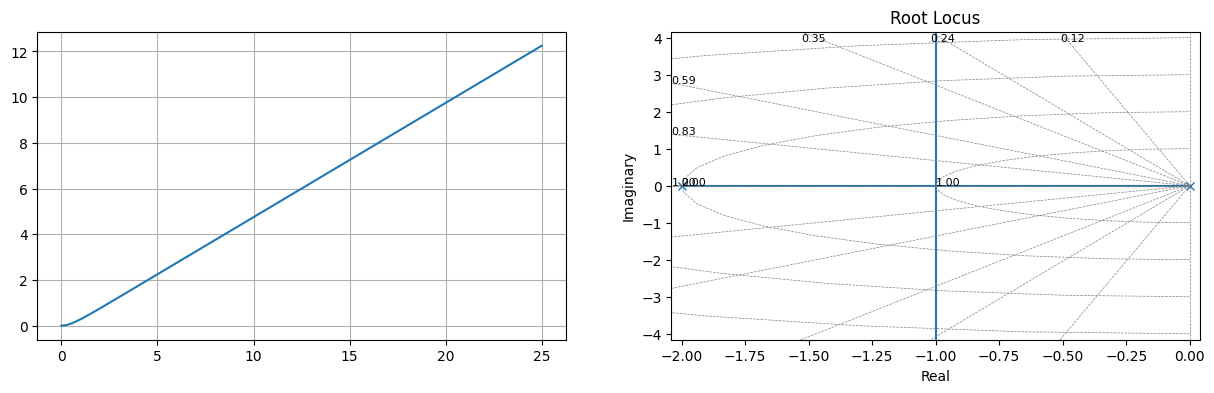

In [24]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DO SISTEMA
- Os requisitos do sistema serão encontrados a partir do overshoot e tempo de establização máximos permitidos

(np.float64(0.4559498107691261), np.float64(4.386447702711552), -2.0 + 3.904*I)

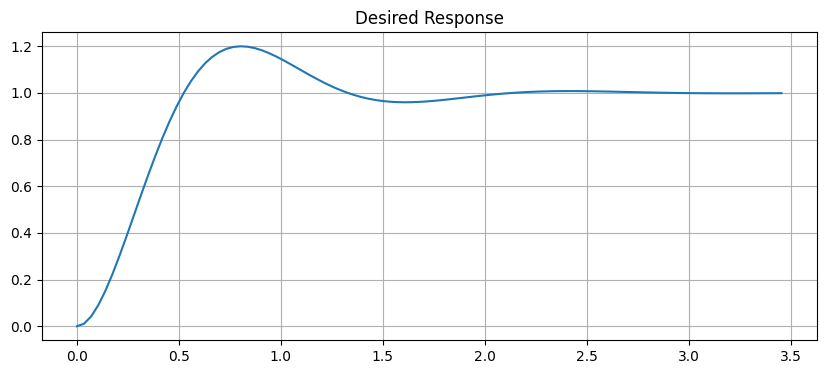

In [25]:
Ts = 2.0
UP = 0.2

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\cdot\frac{(s-a)(s-b)}{s(s-p)}$
- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [26]:
s = sp.symbols('s')
K, a, b = sp.symbols('K a b', real=True)
p = -20

C = K * ((s - a) * (s - b)) / (s * (s - p))
C

K*(-a + s)*(-b + s)/(s*(s + 20))

In [27]:
GC = sympyFunction(G) * C
GC

K*(-a + s)*(-b + s)/(s*(s + 20)*(s**2 + 2*s))

### CONSTANTE DO PRIMEIRO ZERO
- Opção 1: $a$ deve ser um zero que irá cortar com um polo **ESTÁVEL** do sistema, ou seja, localizado no semiplano **ESQUERDO**
- Opção 2: $a$ deve cortar com a parte real do polo estável projetado com $s_d$, caso o seu sistema não tenha outros polos estáveis

In [28]:
a_desired = float(sp.re(s_d))

GC = GC.subs(a, a_desired)
GC

K*(-b + s)*(s + 2.0)/(s*(s + 20)*(s**2 + 2*s))

In [29]:
a = a_desired
a

-2.0

### EQUAÇÃO 1 - SOMA DOS ÂNGULOS
- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [30]:
G_aux = GC.subs(K, 1).subs(s, s_d).simplify()
angle = sp.arg(G_aux)
angle = roundSympyFunction(angle)

eq = sp.Eq(angle + sp.pi, 0)
eq

Eq(arg(1.0*b*(0.001126 - 0.002587*I) - 0.00785 - 0.009569*I) + pi, 0)

In [31]:
b_desired = solveEquation(eq, b)
b_desired

-3.6989113530326594

In [32]:
GC = GC.subs(b, b_desired)
b  = b_desired

GC

K*(s + 2.0)*(s + 3.69891135303266)/(s*(s + 20)*(s**2 + 2*s))

### EQUAÇÃO 2 - MÓDULO
- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [33]:
G_aux  = GC.subs(s, s_d).simplify()
modulo = sp.Abs(G_aux).expand().simplify()
modulo = roundSympyFunction(modulo)

eq = sp.Eq(modulo - 1, 0)
eq

Eq(0.012014*Abs(K) - 1, 0)

In [34]:
K = solveEquation(eq, K)
K

83.23621326493402

# RESPOSTA CONTROLADA

In [35]:
s = ctl.TransferFunction.s
C = K * ((s - a) * (s - b)) / (s * (s - p))

print(sympyFunction(C))
C

(83.236213264934*s**2 + 474.35580075898*s + 615.766748458224)/(s**2 + 20*s)


TransferFunction(array([ 83.23621326, 474.35580076, 615.76674846]), array([ 1, 20,  0]))

In [36]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([ 83.23621326, 474.35580076, 615.76674846]), array([ 1, 22, 40,  0,  0]))

In [37]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 83.23621326, 474.35580076, 615.76674846]), array([  1.        ,  22.        , 123.23621326, 474.35580076,
       615.76674846]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-16+0j) (-2+3.904j) (-2-3.904j) (-2+0j)
zeros:  (-3.699+0j) (-2+0j)


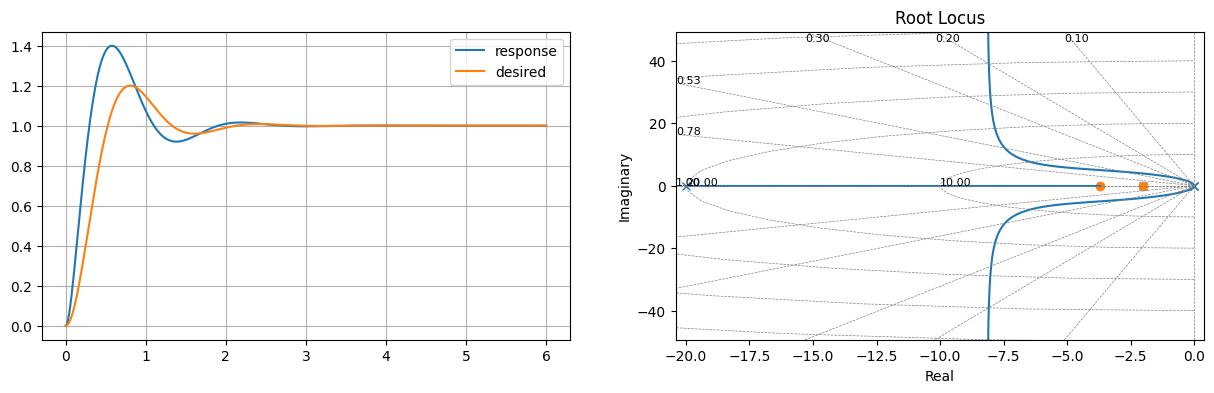

In [38]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [39]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor finalroundSympyFunction(: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.3996331028697183
valor de pico:  1.399629731824113
tempo de pico:  0.5765765765765766
tempo de assentamento:  1.7777777777777777
valor finalroundSympyFunction(:  0.9999975914790824
erro:  2.4085209175961353e-06


# APLICANDO VÁRIOS STEPS

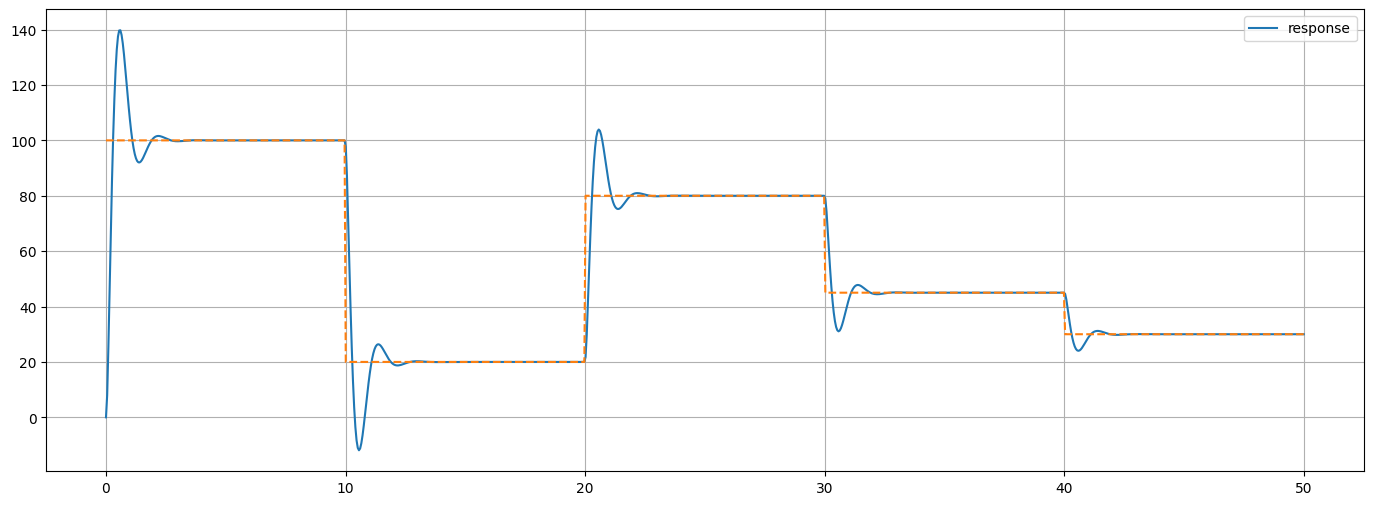

In [40]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()